In [33]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import os
import seaborn as sns
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

from importlib.machinery import SourceFileLoader
plotting = SourceFileLoader("plotting", "../../plotting.py").load_module()

# Import Data

In [2]:
biomes = xr.open_dataset('../data/biomes_regrid_pop.nc')

In [4]:
hourly_mean = xr.open_dataset('../data/monthly_diurnal_cycle.nc')

# Make Map of Diurnal Cycle Magnitude

In [13]:
chl_range = hourly_mean.totChl.groupby('month').max(dim = 'hour') - hourly_mean.totChl.groupby('month').min(dim = 'hour')


/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


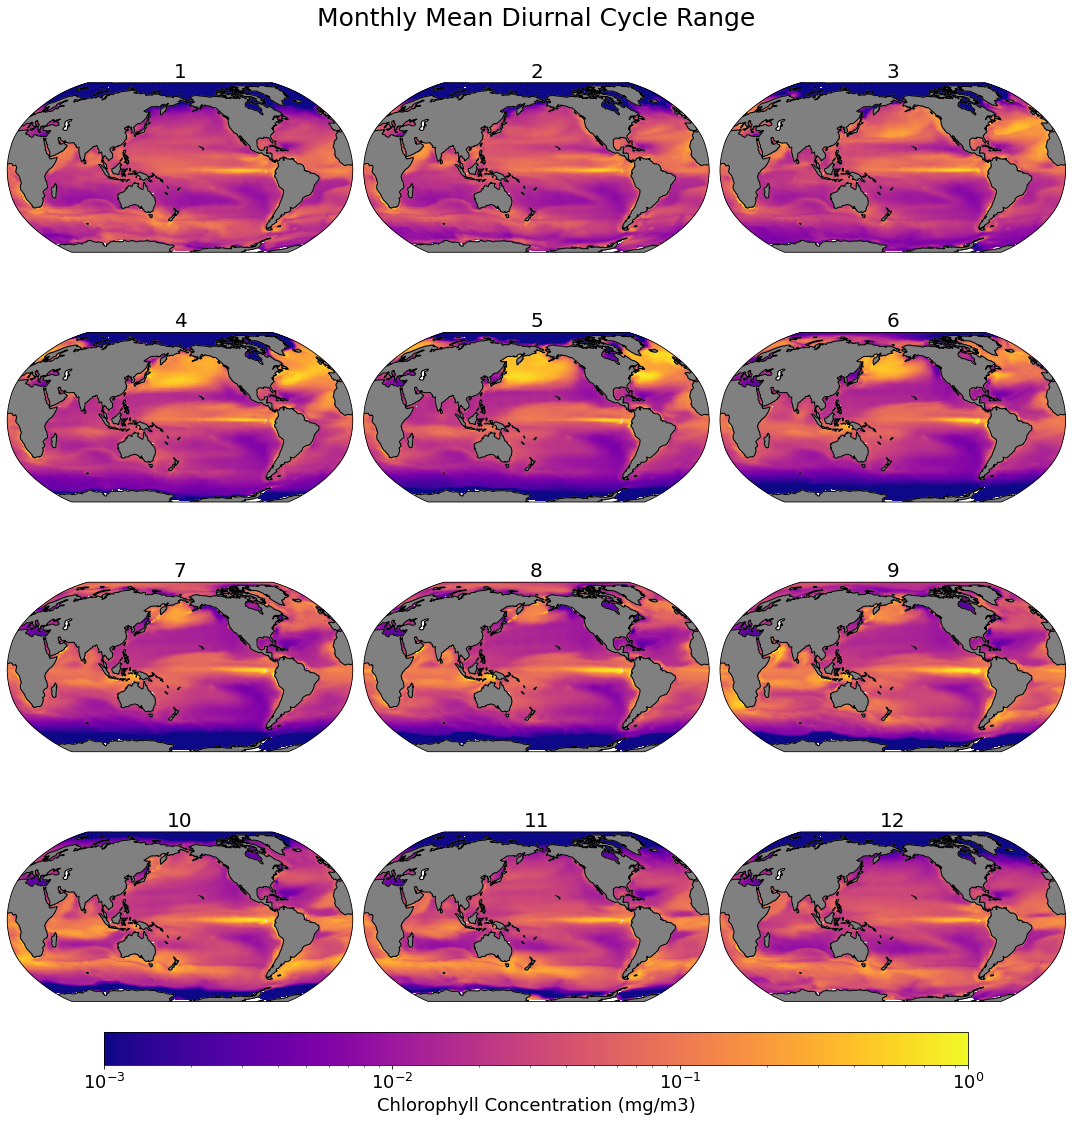

In [44]:
chl_range = hourly_mean.totChl.groupby('month').max(dim = 'hour') - hourly_mean.totChl.groupby('month').min(dim = 'hour')

chl_range_plot = plotting.pop_add_cyclic(chl_range.to_dataset(name = 'totChl'))

fig, axs = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)},
                        figsize=(15,15))

fig.suptitle('Monthly Mean Diurnal Cycle Range', fontsize=25)
axs = axs.flatten()

for i in range(0,12):
    axs[i].set_title(str(i+1), fontsize = 20)

    norm = colors.LogNorm(vmin = 0.001, vmax = 1)
    im1 = axs[i].pcolormesh(chl_range_plot.TLONG, chl_range_plot.TLAT, chl_range_plot.totChl.isel(month=i), 
                       transform = ccrs.PlateCarree(), norm = norm, shading = 'nearest', cmap='plasma')

    axs[i].add_feature(cartopy.feature.LAND, color='grey', zorder =1)
    axs[i].coastlines(color = 'black', linewidth = 1)

# [left, bottom, width, height]
cax = fig.add_axes([0.1, 0, 0.8, 0.03])
cbar = plt.colorbar(im1, cax = cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Chlorophyll Concentration (mg/m3)', size = 18)
plt.tight_layout()
plt.savefig('../plots/diurnal_cycle/monthly_mean_chl_diurnal_range.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)


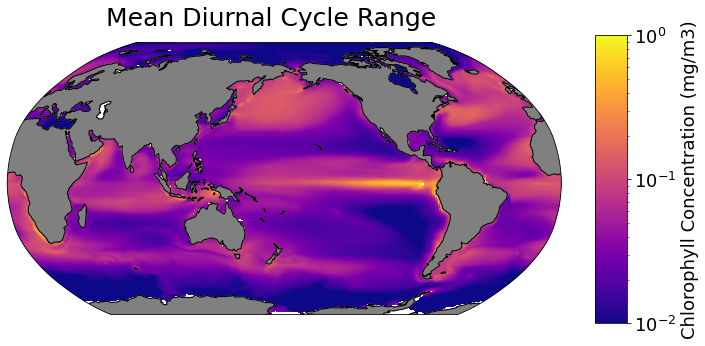

In [45]:
chl_range_annual = chl_range_plot.mean(dim='month')

fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)},
                        figsize=(15,5))

fig.suptitle('Mean Diurnal Cycle Range', fontsize=25)

norm = colors.LogNorm(vmin = 0.01, vmax = 1)
im1 = axs.pcolormesh(chl_range_annual.TLONG, chl_range_annual.TLAT, chl_range_annual.totChl, 
                   transform = ccrs.PlateCarree(), norm = norm, shading = 'nearest', cmap='plasma')

axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

# [left, bottom, width, height]
cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax, orientation='vertical')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Chlorophyll Concentration (mg/m3)', size = 18)
plt.savefig('../plots/diurnal_cycle/mean_chl_diurnal_range.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

# Local time of Min and Max Histograms

In [47]:
local_time_offset = hourly_mean.TLONG/15
hourly_mean['local_time'] = local_time_offset + hourly_mean.hour
hourly_mean['local_time'] = xr.where(hourly_mean.local_time>24, hourly_mean.local_time - 24, hourly_mean.local_time)
hourly_mean = hourly_mean.set_coords('local_time')


In [48]:
hourly_mean['biomes'] = biomes.MeanBiomes
hourly_mean = hourly_mean.set_coords('biomes')

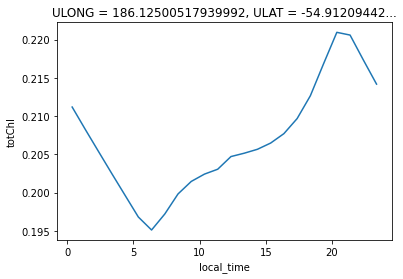

In [14]:
hourly_mean.totChl.isel(nlat=45,nlon=200,month=1).sortby('local_time').plot(x = 'local_time')

Total Mean:    0.20694697
Daylight Mean: 0.2044184
1pm Mean:      0.2031674


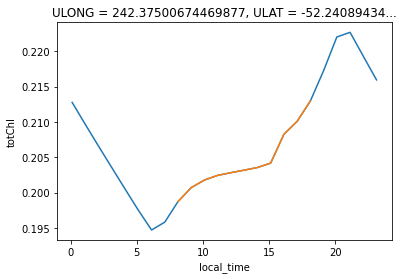

In [85]:
one_point = hourly_mean.isel(nlat=50,nlon=250,month=1)
print('Total Mean:   ', one_point.totChl.mean().data)
print('Daylight Mean:', one_point.where(one_point.daylight>0, drop = True).totChl.mean().data)
print('1pm Mean:     ', one_point.where((one_point.local_time > 13) & (one_point.local_time < 14), drop = True).totChl.data[0])
one_point.totChl.sortby('local_time').plot(x = 'local_time')
one_point.totChl.where(one_point.daylight>0).sortby('local_time').plot(x = 'local_time')

Total Mean:    0.25783512
Daylight Mean: 0.25630072
1pm Mean:      0.25612503


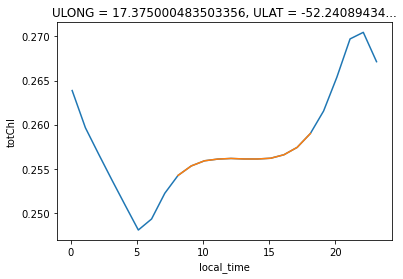

In [86]:
one_point = hourly_mean.isel(nlat=50,nlon=50,month=11)
print('Total Mean:   ', one_point.totChl.mean().data)
print('Daylight Mean:', one_point.where(one_point.daylight>0, drop = True).totChl.mean().data)
print('1pm Mean:     ', one_point.where((one_point.local_time > 13) & (one_point.local_time < 14), drop = True).totChl.data[0])
one_point.totChl.sortby('local_time').plot(x = 'local_time')
one_point.totChl.where(one_point.daylight>0).sortby('local_time').plot(x = 'local_time')

## Seasonal

In [322]:
time_min_DJF= (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.min(dim='hour'), drop = True).where(hourly_mean.month.isin([12,1,2]), drop = True).local_time)
time_min_DJF_df = time_min_DJF.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_min_DJF_df['biomes'] = time_min_DJF_df['biomes'].astype(int)

time_min_JJA = (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.min(dim='hour'), drop = True).where(hourly_mean.month.isin([6,7,8]), drop = True).local_time)
time_min_JJA_df = time_min_JJA.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_min_JJA_df['biomes'] = time_min_JJA_df['biomes'].astype(int)

In [ ]:
time_max_DJF= (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.max(dim='hour'), drop = True).where(hourly_mean.month.isin([12,1,2]), drop = True).local_time)
time_max_DJF_df = time_max_DJF.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_max_DJF_df['biomes'] = time_max_DJF_df['biomes'].astype(int)

time_max_JJA = (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.max(dim='hour'), drop = True).where(hourly_mean.month.isin([6,7,8]), drop = True).local_time)
time_max_JJA_df = time_max_JJA.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_max_JJA_df['biomes'] = time_max_JJA_df['biomes'].astype(int)

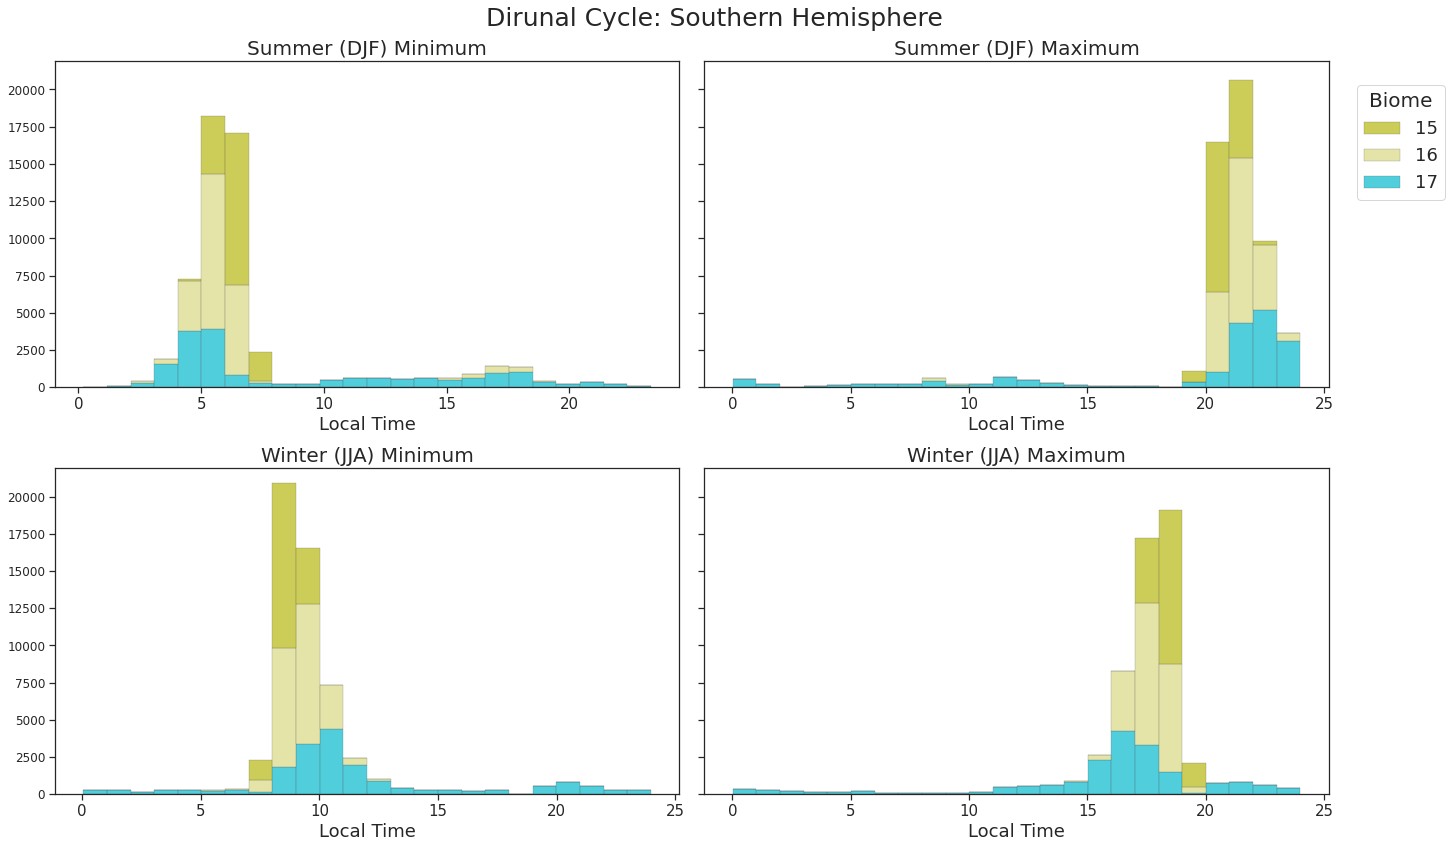

In [392]:
sns.set_theme(style="ticks")
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 12), sharey = True)
axs = axs.flatten()
fig.suptitle('Dirunal Cycle: Southern Hemisphere', fontsize = 25)

ax1 = sns.histplot(
    time_min_DJF_df[time_min_DJF_df['biomes'].isin([15,16,17])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[0], legend = False)
ax1.set_title('Summer (DJF) Minimum', fontsize = 20)

ax2 = sns.histplot(
    time_max_DJF_df[time_max_DJF_df['biomes'].isin([15,16,17])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    hue_norm = plotting.biome_norm,
    palette=plotting.biomes_cmap,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[1], legend = True)
ax2.set_title('Summer (DJF) Maximum', fontsize = 20)
sns.move_legend(ax2, "right", bbox_to_anchor=(0.7, 0.5, 0.5, 0.5), ncol=1, fontsize = 18, title = 'Biome', title_fontsize=20)

ax3 = sns.histplot(
    time_min_JJA_df[time_min_JJA_df['biomes'].isin([15,16,17])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[2], legend = False)
ax3.set_title('Winter (JJA) Minimum', fontsize = 20)

ax4 = sns.histplot(
    time_max_JJA_df[time_max_JJA_df['biomes'].isin([15,16,17])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    hue_norm = plotting.biome_norm,
    palette=plotting.biomes_cmap,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[3], legend = False)
ax4.set_title('Winter (JJA) Maximum', fontsize = 20)


for ax in axs.flat:
    ax.set_ylabel('')
    ax.set_xlabel('Local Time', fontdict = {'fontsize':18}) 
    ax.tick_params(axis='x',labelsize=15)
    ax.tick_params(axis='y',labelsize=12)

plt.tight_layout()
plt.savefig('../plots/chl_min_max_southern_hem.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

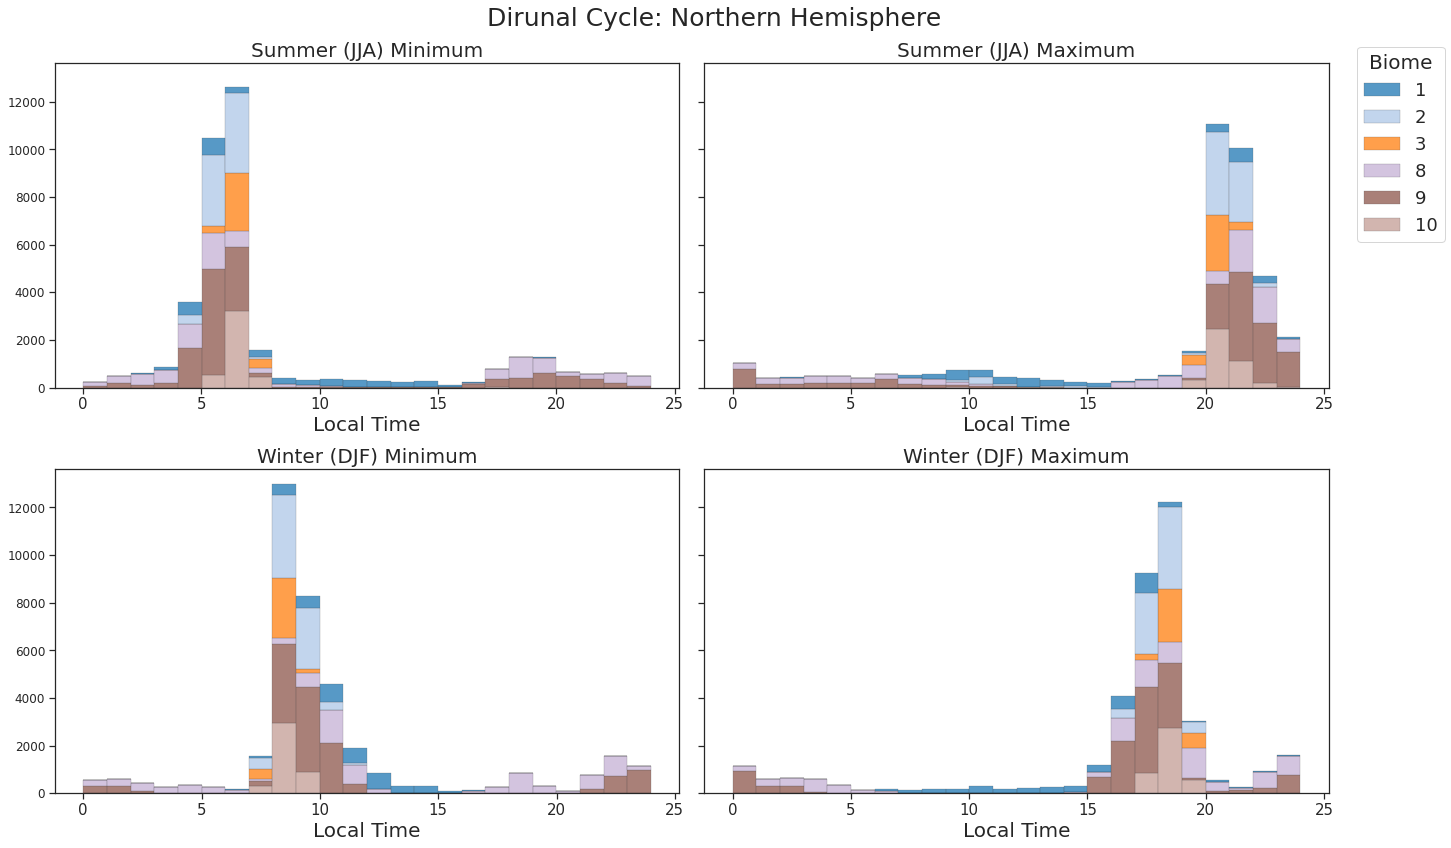

In [393]:
sns.set_theme(style="ticks")
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 12), sharey = True)
axs = axs.flatten()
fig.suptitle('Dirunal Cycle: Northern Hemisphere', fontsize = 25)

ax1 = sns.histplot(
    time_min_JJA_df[time_min_JJA_df['biomes'].isin([1,2,3,8,9,10])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[0], legend = False)
ax1.set_title('Summer (JJA) Minimum', fontsize = 20)

ax2 = sns.histplot(
    time_max_JJA_df[time_max_JJA_df['biomes'].isin([1,2,3,8,9,10])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    hue_norm = plotting.biome_norm,
    palette=plotting.biomes_cmap,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[1], legend = True)
ax2.set_title('Summer (JJA) Maximum', fontsize = 20)
sns.move_legend(ax2, "right", bbox_to_anchor=(0.7, 0.5, 0.5, 0.5), ncol=1, fontsize = 18, title = 'Biome', title_fontsize=20)

ax3 = sns.histplot(
    time_min_DJF_df[time_min_DJF_df['biomes'].isin([1,2,3,8,9,10])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[2], 
    legend = False)
ax3.set_title('Winter (DJF) Minimum', fontsize = 20)

ax4 = sns.histplot(
    time_max_DJF_df[time_max_DJF_df['biomes'].isin([1,2,3,8,9,10])],
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    hue_norm = plotting.biome_norm,
    palette=plotting.biomes_cmap,
    edgecolor=".3",
    linewidth=0.2, 
    ax = axs[3], 
    legend = False)
ax4.set_title('Winter (DJF) Maximum', fontsize = 20)

for ax in axs.flat:
    ax.set_ylabel('')
    ax.set_xlabel('Local Time', fontdict = {'fontsize':20}) 
    ax.tick_params(axis='x',labelsize=15)
    ax.tick_params(axis='y',labelsize=12)

plt.tight_layout()
plt.savefig('../plots/chl_min_max_northern_hem.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

## All Data

In [205]:
time_min = (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.min(dim='hour'), drop = True).local_time)
time_min_df = time_min.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_min_df['biomes'] = time_min_df['biomes'].astype(int)

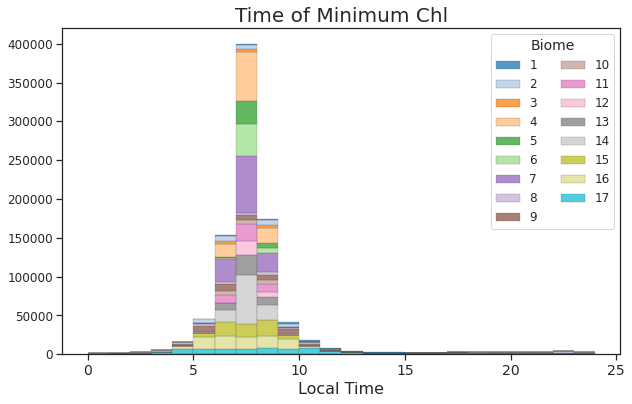

In [396]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.histplot(
    time_min_df,
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2)

sns.move_legend(ax, "upper right", ncol=2, fontsize = 12, title = 'Biome', title_fontsize=14)

plt.xlabel('Local Time', fontsize=16)
plt.ylabel('')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 14)
plt.title('Time of Minimum Chl', fontsize = 20);
plt.savefig('../plots/chl_min_local_time.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [122]:
time_max = (hourly_mean.where(hourly_mean.totChl == hourly_mean.totChl.max(dim='hour'), drop = True).local_time)
time_max_df = time_max.to_dataframe().reset_index()[['biomes','local_time']].dropna()
time_max_df['biomes'] = time_max_df['biomes'].astype(int)

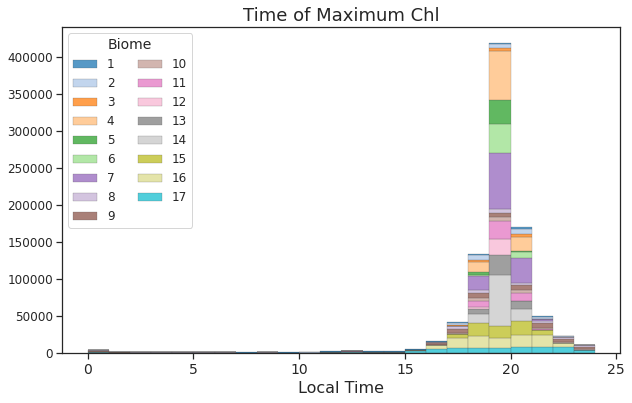

In [395]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.histplot(
    time_max_df,
    x="local_time", hue="biomes",
    bins=24, discrete = False,
    multiple="stack",
    palette=plotting.biomes_cmap,
    hue_norm = plotting.biome_norm,
    edgecolor=".3",
    linewidth=0.2, 
    legend = True)

sns.move_legend(ax, "upper left", ncol=2, fontsize = 12, title = 'Biome', title_fontsize=14)

plt.xlabel('Local Time', fontsize=16)
plt.ylabel('')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 14)
plt.title('Time of Maximum Chl', fontsize = 18);
plt.savefig('../plots/chl_max_local_time.png',bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

# Calculate the anomaly at 1:30pm

In [17]:
month_list = []

for m in range(1,13):
    month = hourly_mean.sel(month=m, drop = True)
    loc_time_1pm_all = month.totChl.mean(dim='hour')
    loc_time_1pm_all = xr.where(loc_time_1pm_all, np.nan, np.nan)
    
    for h in range(0,24):
        loc_time_1pm = month.where((month.local_time>=13)&(month.local_time<14)).isel(hour=h).totChl
        loc_time_1pm_all = xr.where(~loc_time_1pm.isnull(), loc_time_1pm, loc_time_1pm_all)
    
    loc_time_1pm_all['month'] = m
    month_list.append(loc_time_1pm_all)

mean_1pm = xr.concat(month_list, dim='month').compute()

In [25]:
monthly_mean = hourly_mean.mean(dim='hour')
anom_1pm = 100*(mean_1pm - monthly_mean)/monthly_mean

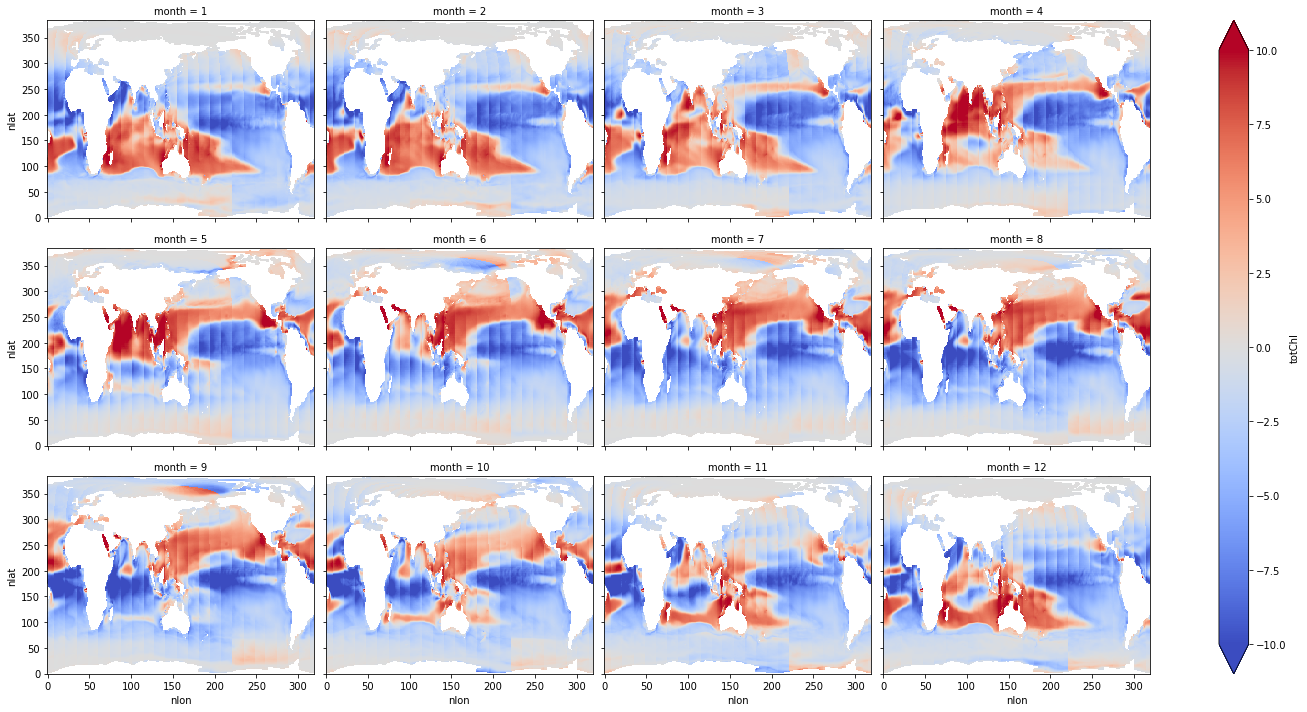

In [48]:
anom_1pm.totChl.plot(col = 'month', col_wrap = 4, vmax = 10, figsize=(20,10), cmap = 'coolwarm')

In [40]:
anom_1pm_year = 100*(mean_1pm.mean(dim='month') - monthly_mean.mean(dim='month'))/ monthly_mean.mean(dim='month')

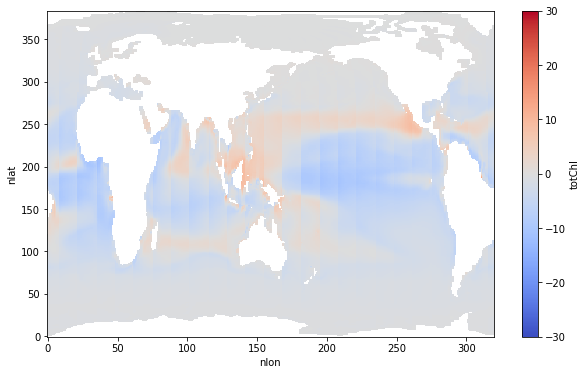

In [49]:
anom_1pm_year.totChl.plot(vmax = 30, cmap = 'coolwarm', figsize = (10,6))

This plot explains most of the differences in the low latitude baseline swath - no swath climatology plots. But what about the large differences at high latitudes? Does it have to do with the number of times that we view the grid cell?